# Workshop Tutorial: Running Jobs on OTHER Compute Resources

PHOEBE currently (in the `workshop2021` version) supports running jobs on [external compute resources running a slurm scheduler](./Tutorial_09_server.ipynb).  But until we add support for more configurations, you can always manually run jobs on an external machine.

In [1]:
import phoebe

b = phoebe.default_binary()
b.add_dataset('lc', compute_phases=phoebe.linspace(0,1,501))

<ParameterSet: 78 parameters | contexts: dataset, constraint, figure, compute>

Instead of calling `run_compute`, call [export_compute](http://phoebe-project.org/docs/2.3/api/phoebe.frontend.bundle.Bundle.export_compute.md) (or [export_solver](http://phoebe-project.org/docs/2.3/api/phoebe.frontend.bundle.Bundle.export_solver.md) instead of `run_solver`).  These take the same arguments, _except_ that the first argument is the filename of a script that will be produced.

In [2]:
b.export_compute('export_compute.py', irrad_method='none')

('export_compute.py', 'export_compute.py.out')

This then returns the name of the script as well as the name of the output file that will be created when running that script (you can also override this by passing `out_fname` to the export method).

Let's take a quick peak at what's in this script.

In [3]:
!cat export_compute.py

import os; os.environ['PHOEBE_ENABLE_PLOTTING'] = 'FALSE'; os.environ['PHOEBE_ENABLE_SYMPY'] = 'FALSE';
import phoebe; import json;
bdict = json.loads('[{"qualifier": "t0", "context": "system", "value": 0.0, "default_unit": "d", "limits": [null, null], "Class": "FloatParameter"}, {"qualifier": "ra", "context": "system", "value": 0.0, "default_unit": "deg", "limits": [null, null], "Class": "FloatParameter"}, {"qualifier": "dec", "context": "system", "value": 0.0, "default_unit": "deg", "limits": [null, null], "Class": "FloatParameter"}, {"qualifier": "distance", "context": "system", "value": 1.0, "default_unit": "m", "limits": [null, null], "Class": "FloatParameter"}, {"qualifier": "vgamma", "context": "system", "value": 0.0, "default_unit": "km / s", "limits": [null, null], "Class": "FloatParameter"}, {"qualifier": "ebv", "context": "system", "value": 0.0, "default_unit": "", "limits": [null, null], "Class": "FloatParameter"}, {"qualifier": "Av", "context": "system", "value": 0.0, "def

Now copy this script to your server of choice, make sure phoebe is installed, and run or submit to the scheduler.

For the sake of this tutorial, we'll just run it locally in the notebook (you may need to make sure this runs in the same environment or change `python3` to whatever you use on your system for phoebe).

In [4]:
!python3 export_compute.py

100%|█████████████████████████████████████████| 501/501 [00:08<00:00, 61.08it/s]


This then creates the `export_compute.py.out` file (and for solvers with `progress_every_niters`, would create `export_compute.py.out.progress` for intermediate outputs).  Just copy this file back to your local machine and then load it using [b.import_model](http://phoebe-project.org/docs/2.3/api/phoebe.frontend.bundle.Bundle.import_model.md) or [b.import_solution](http://phoebe-project.org/docs/2.3/api/phoebe.frontend.bundle.Bundle.import_solution.md).

If you already passed `model` or `solution` to the export method, that tag will be used by default.  But you can also override during import.

In [5]:
b.import_model('export_compute.py.out', model='model_from_export')

<ParameterSet: 3 parameters | qualifiers: times, comments, fluxes>

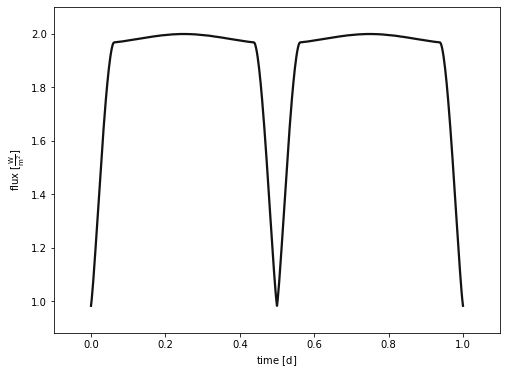

In [6]:
_ = b.plot(model='model_from_export', show=True)

## Preview: Using AWS Server

**IMPORTANT**: this should currently be considered *experimental* and is subject to changes before being released.  See [running jobs on external compute resources](./Tutorial_09_server.ipynb) for general options and running jobs on a Remote Slurm Machine.

Follow the [crimpl AWS configuration steps](https://crimpl.readthedocs.io/en/latest/AWSEC2.html) and create and save a crimpl configuration called `'aws'`.

In [7]:
b.add_server('awsec2', crimpl_name='aws', server='aws')

<ParameterSet: 7 parameters | qualifiers: terminate_on_complete, crimpl_name, conda_env, nprocs, use_mpi, isolate_env, install_deps>

In [8]:
print(b.filter(server='aws'))

ParameterSet: 7 parameters
           crimpl_name@aws@server: aws
             conda_env@aws@server: default
           isolate_env@aws@server: False
                nprocs@aws@server: 4
               use_mpi@aws@server: True
          install_deps@aws@server: True
   terminate_on_complete@aws@s...: True


`terminate_on_complete`: if `True` the AWS EC2 instance will immediately terminate once the job is completed, but the volume will remain active.  Retrieving the results will then spawn a new EC2 instance on the fly.  This is useful for long jobs where you may not be checking the results quickly, but adds extra overhead (and cost) for short jobs.

In [9]:
b.set_value('terminate_on_complete', False)
b.set_value('use_mpi', False)
b.set_value('conda_env', 'phoebe_workshop')

Since this is the first time creating this server, the following steps will happen:
* a single-processor EC2 instance will be created and a new volume created and attached
* any setup/installation will be completed
* this single-processor instance will be terminated
* a new EC2 instance with `nprocs` will be launched and the persistent volume attached
* the job will be run
* if `terminate_on_complete=True`: the multi-proc EC2 instance is terminated, and future checks for status/output files will launch a new single-processor EC2

Note that otherwise, you are responsible for terminating the instance and/or deleting the volume!

In [ ]:
b.run_compute(use_server='aws')

In [ ]:
_ = b.plot(show=True)

### Checking and Managing AWS Resources

It is most convenient to manage the state of EC2 instances and volumes from the [AWSEC2Server](https://crimpl.readthedocs.io/en/latest/api/AWSEC2Server.md) and [AWSEC2Job](https://crimpl.readthedocs.io/en/latest/api/AWSEC2Job.md) methods themselves.  However, top-level functions also exist to list all active instances and volumes within EC2 that are managed by **crimpl**.

* [list_awsec2_instances](https://crimpl.readthedocs.io/en/latest/api/crimpl.list_awsec2_instances.md)
* [list_awsec2_volumes](https://crimpl.readthedocs.io/en/latest/api/crimpl.list_awsec2_volumes.md)

If an instance or volume is running that is no longer needed, they can be manually terminated/deleted via:

* [terminate_awsec2_instance](https://crimpl.readthedocs.io/en/latest/api/crimpl.terminate_awsec2_instance.md)
* [delete_awsec2_volume](https://crimpl.readthedocs.io/en/latest/api/crimpl.delete_awsec2_volume.md)

Or all instances/volumes managed by crimpl can be terminated/deleted at once:

* [terminate_all_awsec2_instances](https://crimpl.readthedocs.io/en/latest/api/crimpl.terminate_all_awsec2_instances.md)
* [delete_all_awsec2_volumes](https://crimpl.readthedocs.io/en/latest/api/crimpl.delete_all_awsec2_volumes.md)

And it never hurts to check the online AWS dashboard to make sure that there are no unexpected running services that could result in charges:

* [AWS EC2 Instances Dashboard](https://console.aws.amazon.com/ec2/v2/home#Instances:)
* [AWS EC2 Volumes Dashboard](https://console.aws.amazon.com/ec2/v2/home#Volumes:sort=desc:createTime)

In [ ]:
print(phoebe.dependencies.crimpl.list_awsec2_instances())
print(phoebe.dependencies.crimpl.list_awsec2_volumes())

There are several ways we can access the **crimpl** server object:

In [ ]:
s = phoebe.dependencies.crimpl.load_server('aws')

In [ ]:
s = b.get_server_crimpl_object(server='aws')

In [ ]:
s.terminate(delete_volume=True)

In [ ]:
print(phoebe.dependencies.crimpl.list_awsec2_instances())
print(phoebe.dependencies.crimpl.list_awsec2_volumes())